In [16]:
# ============================================================
# CUSTOMER SEGMENTATION & LIFETIME VALUE PREDICTION PROJECT
# Using Online Retail II Dataset (UCI / Kaggle)
# Author: Ege Bakalım
# ============================================================

# ---------------------------
# 1. Import Dependencies
# ---------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

sns.set(style="whitegrid")
plt.style.use("seaborn-v0_8")

# ---------------------------
# 2. Load Dataset
# ---------------------------
# IMPORTANT:
# Download dataset from Kaggle: "Online Retail II"
# Use the 2010-2011 sheet
# ---------------------------

file_path = "../online_retail_II.csv"  
df = pd.read_csv(file_path)
df.head()


df.columns


Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')

In [17]:
# ---------------------------
# 3. Basic Cleaning
# ---------------------------
print("Initial shape:", df.shape)

# Remove rows with missing CustomerID
df = df[df["Customer ID"].notnull()]

# Remove negative or zero quantities
df = df[df["Quantity"] > 0]

# Remove negative or zero prices
df = df[df["Price"] > 0]

# Rename columns for convenience
df.rename(columns={
    "Invoice": "InvoiceNo",
    "StockCode": "StockCode",
    "Description": "Description",
    "Quantity": "Quantity",
    "InvoiceDate": "InvoiceDate",
    "Price": "UnitPrice",
    "Customer ID": "CustomerID",
    "Country": "Country"
}, inplace=True)

df.head()


Initial shape: (1067371, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [18]:
# ---------------------------
# 4. Compute Total Monetary Value
# ---------------------------
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [20]:
# ---------------------------
# 5. RFM Table
# ---------------------------

# 1) Make sure InvoiceDate is in datetime format
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], errors="coerce")

# 2) Drop rows where the date could not be parsed (NaT)
df = df[df["InvoiceDate"].notna()]

# 3) Reference date: one day after the last purchase
ref_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

# 4) Build the RFM table
rfm = df.groupby("CustomerID").agg({
    "InvoiceDate": lambda x: (ref_date - x.max()).days,  # Recency
    "InvoiceNo": "nunique",                              # Frequency
    "TotalPrice": "sum"                                  # Monetary
})

# 5) Rename columns
rfm.columns = ["Recency", "Frequency", "Monetary"]

rfm.head()


,Recency,Frequency,Monetary
CustomerID,,,
12346.0,326,12,77556.46
12347.0,2,8,5633.32
12348.0,75,5,2019.40
12349.0,19,4,4428.69
12350.0,310,1,334.40


c:\Users\pc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\pc\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\pc\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\pc\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\pc\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable

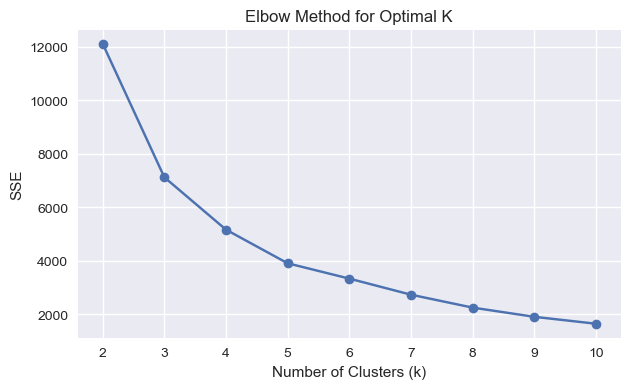

In [21]:
# ---------------------------
# 6. Scaling
# ---------------------------
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# ---------------------------
# 7. Find Optimal K (Elbow Method)
# ---------------------------
sse = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, n_init=10)
    km.fit(rfm_scaled)
    sse.append(km.inertia_)

plt.figure(figsize=(7,4))
plt.plot(K_range, sse, marker="o")
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("SSE")
plt.show()


In [ ]:
# ---------------------------
# 8. K-Means Clustering on RFM
# ---------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Use only RFM columns for clustering
rfm_features = rfm[["Recency", "Frequency", "Monetary"]]

# Scale the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)

# Choose number of clusters (you can change 4 if you want)
k = 4
kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(rfm_scaled)

# Add cluster labels to RFM table
rfm["Cluster"] = cluster_labels

# Optional: inspect the result
rfm.head()


C:\Users\pc\AppData\Roaming\Python\Python312\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=23.
  warnings.warn(


,Recency,Frequency,Monetary,Cluster
CustomerID,,,,
12346.0,326,12,77556.46,1
12347.0,2,8,5633.32,1
12348.0,75,5,2019.40,1
12349.0,19,4,4428.69,1
12350.0,310,1,334.40,0


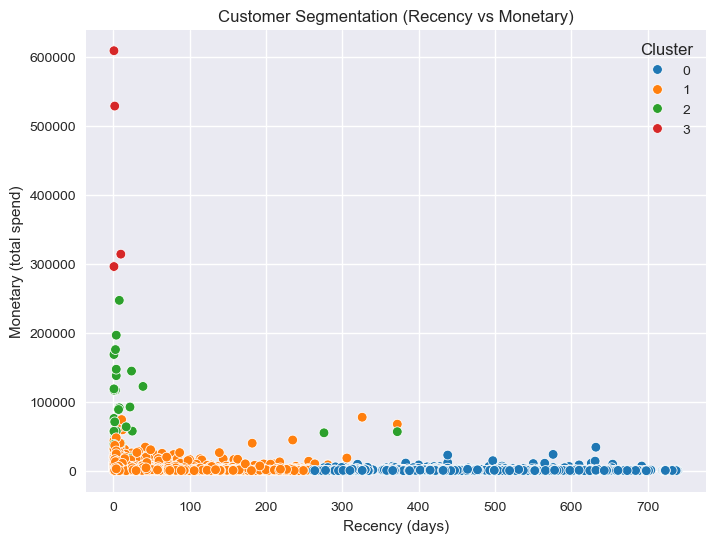

In [24]:
# ---------------------------
# 9. Visualize Recency vs Monetary
# ---------------------------
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm,
    x="Recency", 
    y="Monetary",
    hue="Cluster", 
    palette="tab10"
)
plt.title("Customer Segmentation (Recency vs Monetary)")
plt.xlabel("Recency (days)")
plt.ylabel("Monetary (total spend)")
plt.show()


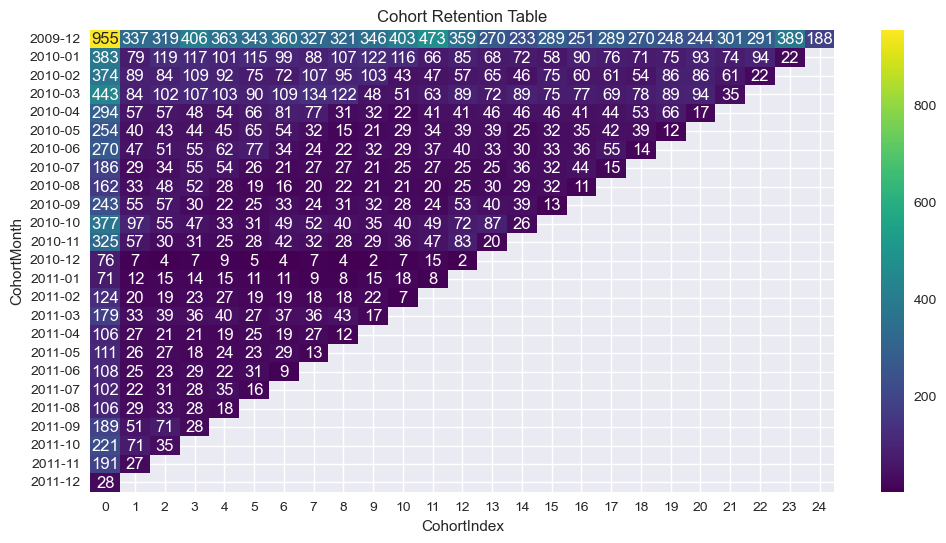

In [25]:
# ---------------------------
# 10. Cohort Analysis
# ---------------------------

df["InvoiceMonth"] = df["InvoiceDate"].dt.to_period("M")
df["CohortMonth"] = df.groupby("CustomerID")["InvoiceMonth"].transform("min")

# Cohort index = months since first purchase
df["CohortIndex"] = (df["InvoiceMonth"] - df["CohortMonth"]).apply(lambda x: x.n)

cohort = df.groupby(["CohortMonth", "CohortIndex"])["CustomerID"].nunique().reset_index()
cohort_pivot = cohort.pivot(index="CohortMonth", columns="CohortIndex", values="CustomerID")

plt.figure(figsize=(12,6))
sns.heatmap(cohort_pivot, cmap="viridis", annot=True, fmt=".0f")
plt.title("Cohort Retention Table")
plt.show()


LTV = Total revenue in next 90 days

In [26]:
# ---------------------------
# 11. Prepare LTV Dataset
# ---------------------------
df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

# Define cutoff date for train/test
cutoff = df["InvoiceDate"].quantile(0.75)

# Past period (feature window)
past = df[df["InvoiceDate"] <= cutoff]

# Future period (target window)
future = df[df["InvoiceDate"] > cutoff]

# Compute future LTV per customer
future_ltv = future.groupby("CustomerID")["TotalPrice"].sum()
future_ltv = future_ltv.rename("LTV")

# Merge with RFM features
ltv_df = rfm.merge(future_ltv, left_index=True, right_index=True, how="left")
ltv_df["LTV"] = ltv_df["LTV"].fillna(0)

ltv_df.head()


,Recency,Frequency,Monetary,Cluster,LTV
CustomerID,,,,,
12346.0,326,12,77556.46,1,0.00
12347.0,2,8,5633.32,1,2104.05
12348.0,75,5,2019.40,1,310.00
12349.0,19,4,4428.69,1,1757.55
12350.0,310,1,334.40,0,0.00


In [28]:
# ---------------------------
# 12. Train/Test Split
# ---------------------------
X = ltv_df[["Recency", "Frequency", "Monetary"]]
y = ltv_df["LTV"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------------
# 13. Train LGBM Model
# ---------------------------
model = LGBMRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))

# RMSE (manual version for older sklearn)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
print("RMSE:", rmse)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 4702, number of used features: 3
[LightGBM] [Info] Start training from score 751.994353
MAE: 447.8185233129523
RMSE: 3829.47294414384


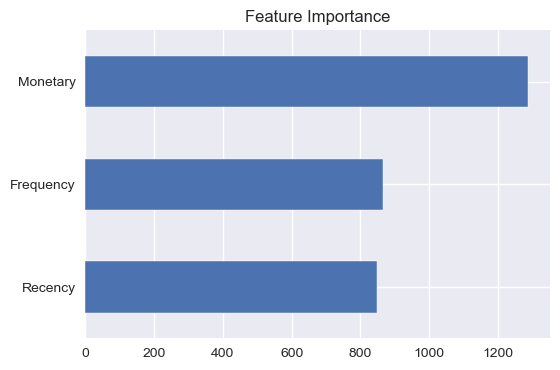

In [29]:
# ---------------------------
# 14. Feature Importance
# ---------------------------
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", figsize=(6,4))
plt.title("Feature Importance")
plt.show()
